In [1]:
import numpy as np  # For numerical operations and array manipulations
import torch  # Core PyTorch library for tensor operations
import torch.nn as nn  # For building neural network layers
import torch.nn.functional as F  # For functional operations like activation functions, loss, etc.
import matplotlib.pyplot as plt  # For visualizing data and results (e.g., PSFs)
import pyzdde.zdde as pyz  # For communicating with Zemax via DDE interface
import os  # For file and path manipulations
from omegaconf import OmegaConf  # For loading and managing YAML/structured configuration files

In [2]:
# Load dataset configuration YAML file as an OmegaConf object
dataset_config = OmegaConf.load('../dataset_config.yaml')

# Load model configuration YAML file as an OmegaConf object
model_config = OmegaConf.load('../model_config.yaml')

# Merge both dataset and model configurations into a single config object
config = OmegaConf.merge(dataset_config, model_config)


In [10]:
# Create a DDE link object to communicate with Zemax via PyZDDE
ln = pyz.createLink()

# Construct the full file path to the Zemax lens file using the config
zfile = os.path.join(ln.zGetPath()[1], 'Sequential', 'Objectives', config['zemax']['lens_file_path'])

# Load the Zemax lens file into the DDE session
ln.zLoadFile(zfile)


0

In [11]:
def apply_mirror_alignment(
    primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt,
    primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt,
    primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt,
    primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt,
    primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt,
    primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt,
    secondary_mirror_piston, secondary_mirror_tip, secondary_mirror_tilt,
    output_scale='linear', root_n=2):
    """
    Sets piston, tip, and tilt values for all 6 primary mirror segments and the secondary mirror.
    Displays PSF in linear, log, or nth root scale.
    """
    wavelength = 0.632  # um
    
    segment_values = [
        (primary_segment_1_piston, primary_segment_1_tip, primary_segment_1_tilt),
        (primary_segment_2_piston, primary_segment_2_tip, primary_segment_2_tilt),
        (primary_segment_3_piston, primary_segment_3_tip, primary_segment_3_tilt),
        (primary_segment_4_piston, primary_segment_4_tip, primary_segment_4_tilt),
        (primary_segment_5_piston, primary_segment_5_tip, primary_segment_5_tilt),
        (primary_segment_6_piston, primary_segment_6_tip, primary_segment_6_tilt),
    ]
    
    for seg_idx, (piston_lambda, tip_lambda, tilt_lambda) in enumerate(segment_values):
        piston_mm = (piston_lambda / 1000) * wavelength
        tip_deg = np.degrees(np.arctan((wavelength * tip_lambda) / 125180))
        tilt_deg = np.degrees(np.arctan((wavelength * tilt_lambda) / 125180))
        
        print(f"Primary Segment {seg_idx+1}: Piston = {piston_lambda} lambda ({piston_mm} mm), "
              f"Tip = {tip_lambda} lambda ({tip_deg} deg), "
              f"Tilt = {tilt_lambda} lambda ({tilt_deg} deg)")
        
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=3, data=float(piston_mm))
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=4, data=float(tip_deg))
        ln.zSetNSCPosition(surfNum=4, objNum=seg_idx * 2 + 1, code=5, data=float(tilt_deg))
    
    # Convert secondary mirror values
    sec_piston_mm = (secondary_mirror_piston / 1000) * wavelength
    sec_tip_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tip) / 61000))
    sec_tilt_deg = np.degrees(np.arctan((wavelength * secondary_mirror_tilt) / 61000))
    
    print(f"Secondary Mirror: Piston = {secondary_mirror_piston} lambda ({sec_piston_mm} mm), "
          f"Tip = {secondary_mirror_tip} lambda ({sec_tip_deg} deg), "
          f"Tilt = {secondary_mirror_tilt} lambda ({sec_tilt_deg} deg)")
    
    ln.zSetThickness(surfNum=6, value=float(sec_piston_mm))
    ln.zSetSurfaceParameter(surfNum=6, param=3, value=float(sec_tip_deg))
    ln.zSetSurfaceParameter(surfNum=6, param=4, value=float(sec_tilt_deg))
    
    # Retrieve and return PSF
    psf_list = ln.zGetPSF('fft')[1]
    psf_array = np.array(psf_list)
    
    plt.figure()
    if output_scale == 'log':
        plt.imshow(np.log(psf_array), cmap='gray')
        plt.title("Log Scale PSF Image")
    elif output_scale == 'nth_root':
        plt.imshow(psf_array ** (1 / root_n), cmap='gray')
        plt.title(f"Nth Root Scale PSF Image (n={root_n})")
    else:
        plt.imshow(psf_array, cmap='gray')
        plt.title("Linear Scale PSF Image")
    
    plt.colorbar()
    plt.show()
    
    return psf_array


Primary Segment 1: Piston = 0.65 lambda (0.0004108 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 2: Piston = 0.23 lambda (0.00014536 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 3: Piston = 0.78 lambda (0.00049296 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 4: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 5: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 6: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Secondary Mirror: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)


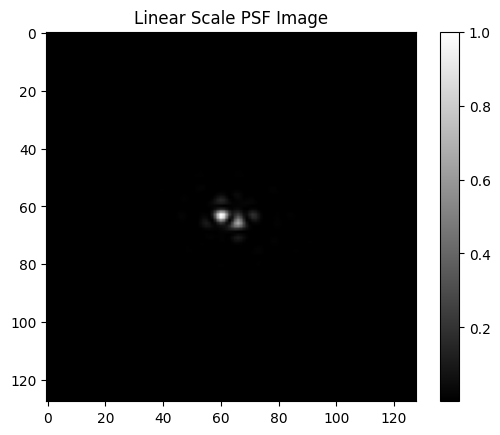

In [12]:
img_nominal = apply_mirror_alignment(
    primary_segment_1_piston= 0.65, primary_segment_1_tip = 0, primary_segment_1_tilt = 0,
    primary_segment_2_piston = 0.23, primary_segment_2_tip = 0, primary_segment_2_tilt = 0,
    primary_segment_3_piston = 0.78, primary_segment_3_tip = 0, primary_segment_3_tilt = 0,
    primary_segment_4_piston = 0, primary_segment_4_tip = 0, primary_segment_4_tilt = 0,
    primary_segment_5_piston = 0, primary_segment_5_tip = 0, primary_segment_5_tilt = 0,
    primary_segment_6_piston = 0, primary_segment_6_tip = 0, primary_segment_6_tilt = 0,
    secondary_mirror_piston = 0, secondary_mirror_tip = 0, secondary_mirror_tilt = 0,
    output_scale='linear', root_n=2)

Primary Segment 1: Piston = 0.65 lambda (0.0004108 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 2: Piston = 0.23 lambda (0.00014536 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 3: Piston = 0.78 lambda (0.00049296 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 4: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 5: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Primary Segment 6: Piston = 0 lambda (0.0 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)
Secondary Mirror: Piston = 10 lambda (0.00632 mm), Tip = 0 lambda (0.0 deg), Tilt = 0 lambda (0.0 deg)


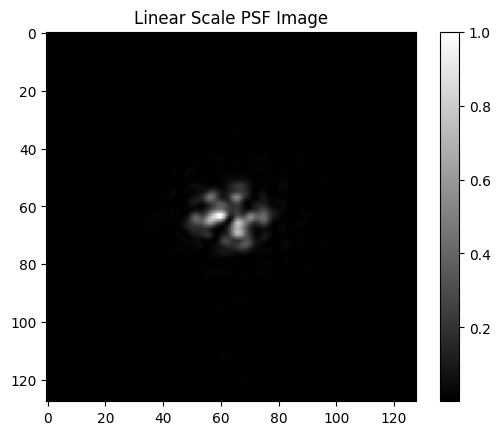

In [13]:
img_defocused = apply_mirror_alignment(
    primary_segment_1_piston= 0.65, primary_segment_1_tip = 0, primary_segment_1_tilt = 0,
    primary_segment_2_piston = 0.23, primary_segment_2_tip = 0, primary_segment_2_tilt = 0,
    primary_segment_3_piston = 0.78, primary_segment_3_tip = 0, primary_segment_3_tilt = 0,
    primary_segment_4_piston = 0, primary_segment_4_tip = 0, primary_segment_4_tilt = 0,
    primary_segment_5_piston = 0, primary_segment_5_tip = 0, primary_segment_5_tilt = 0,
    primary_segment_6_piston = 0, primary_segment_6_tip = 0, primary_segment_6_tilt = 0,
    secondary_mirror_piston = 10, secondary_mirror_tip = 0, secondary_mirror_tilt = 0,
    output_scale='linear', root_n=2)

In [14]:
def extract_parameters(config):
    # Initialize lists for categorized parameters
    to_predict = []           # Parameters with training ranges
    untrained_predict = []    # Parameters with unseen test-time ranges
    not_to_predict = []       # Parameters with fixed static values

    # Iterate over all primary mirror segments
    for segment in config["primary_mirror"]["segments"]:
        seg_id = segment["id"]
        for param in ["piston", "tip", "tilt"]:
            param_config = segment[param]                    # Access parameter config (dict with 'range', 'static', etc.)
            param_name = f"primary_{seg_id}_{param}"         # Generate full parameter name (e.g., "primary_1_piston")

            # Classify parameter based on configuration keys
            if "range" in param_config:
                to_predict.append(param_name)                # Used for model training
            elif "untrained_range" in param_config:
                untrained_predict.append(param_name)         # Seen only during testing, for generalization check
            elif "static" in param_config:
                not_to_predict.append(param_name)            # Fixed value, excluded from model training

    # Handle secondary mirror parameters
    for param in ["piston", "tip", "tilt"]:
        param_config = config["secondary_mirror"][param]
        param_name = f"secondary_{param}"

        if "range" in param_config:
            to_predict.append(param_name)
        elif "untrained_range" in param_config:
            untrained_predict.append(param_name)
        elif "static" in param_config:
            not_to_predict.append(param_name)

    # Return all categorized parameter lists
    return to_predict, untrained_predict, not_to_predict


In [15]:
to_predict, untrained_predict, not_to_predict = extract_parameters(config)
to_predict

['primary_1_piston', 'primary_2_piston', 'primary_3_piston']

In [16]:
class ResNetRegression(nn.Module):
    def __init__(self, config, num_outputs):
        super(ResNetRegression, self).__init__()

        # Store config and determine if phase magnitude input is used
        self.cfg = config["model"]
        self.use_phase_mag = config["dataset"]["use_phase_mag"]
        self.merge_strategy = self.cfg["add_magnitude_ann"]["merge_strategy"] if self.use_phase_mag else None

        # Determine image size and input channels from Zemax sampling and defocus usage
        zemax_sampling = config["zemax"]["sampling"]
        self.image_size = 64 * zemax_sampling
        self.input_channels = 2 if config["dataset"]["use_defocus"] else 1
        self.output_dim = num_outputs

        # Create convolutional layers from YAML configuration
        self.conv_layers = nn.ModuleList()
        in_channels = self.input_channels
        for layer_cfg in self.cfg["conv_layers"]:
            out_channels = layer_cfg["out_channels"]
            kernel_size = layer_cfg["kernel_size"]
            padding = kernel_size // 2
            activation = layer_cfg.get("activation", True)

            block = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False)]
            if activation:
                block.append(nn.ReLU())
            if layer_cfg["pooling"]:
                block.append(nn.MaxPool2d(kernel_size=2, stride=2))

            self.conv_layers.append(nn.Sequential(*block))
            in_channels = out_channels

        # Build skip connection operations based on type ("conv+pool" or "add")
        self.skip_connections = self.cfg["skip_connections"]
        self.skip_ops = nn.ModuleDict()
        for skip in self.skip_connections:
            from_layer = skip["from_layer"]
            to_layer = skip["to_layer"]
            skip_type = skip["type"]
            in_ch = self.cfg["conv_layers"][from_layer]["out_channels"]
            out_ch = self.cfg["conv_layers"][to_layer]["out_channels"]

            if skip_type == "conv+pool":
                self.skip_ops[f"{from_layer}->{to_layer}"] = nn.Sequential(
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)
                )
            elif skip_type == "add":
                self.skip_ops[f"{from_layer}->{to_layer}"] = nn.Identity()

        # Calculate flattened feature map size after all pooling layers
        pool_count = sum(1 for l in self.cfg["conv_layers"] if l["pooling"])
        spatial_dim = self.image_size // (2 ** pool_count)
        final_out_channels = self.cfg["conv_layers"][-1]["out_channels"]
        flatten_dim = final_out_channels * spatial_dim * spatial_dim

        # Fully connected layers for CNN branch
        self.fc_layers = nn.ModuleList()
        in_dim = flatten_dim
        for dim in self.cfg["fc_layers"]:
            self.fc_layers.append(nn.Linear(in_dim, dim))
            in_dim = dim
        self.final_cnn_out_dim = in_dim

        # Fully connected ANN branch for phase magnitude (if enabled)
        if self.use_phase_mag:
            ann_hidden = self.cfg["add_magnitude_ann"]["hidden_layers"]
            self.ann_layers = nn.ModuleList()

            # Input is phase magnitude row + col (nominal + defocus if used)
            ann_in_dim = self.image_size * 2
            if config["dataset"]["use_defocus"]:
                ann_in_dim *= 2

            for dim in ann_hidden:
                self.ann_layers.append(nn.Linear(ann_in_dim, dim))
                ann_in_dim = dim
            self.ann_out_dim = ann_in_dim

            # Merge CNN and ANN outputs depending on strategy
            if self.merge_strategy == "concat":
                merged_dim = self.final_cnn_out_dim + self.ann_out_dim
            elif self.merge_strategy == "add":
                assert self.final_cnn_out_dim == self.ann_out_dim, "Merge='add' requires ANN and CNN dims to match"
                merged_dim = self.final_cnn_out_dim

            # Final prediction layer after merging
            self.fc_out = nn.Linear(merged_dim, self.output_dim)
        else:
            # Final prediction layer if no ANN branch
            self.fc_out = nn.Linear(self.final_cnn_out_dim, self.output_dim)

    def forward(self, *inputs):
        # Separate inputs if phase magnitude is used
        if self.use_phase_mag:
            x, magnitude_tensors = inputs
        else:
            x = inputs[0]

        outputs = []
        # Forward pass through convolutional layers with skip connections
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            outputs.append(x)

            # Apply any skip connections targeting current layer
            for skip in self.skip_connections:
                if skip["to_layer"] == i:
                    from_layer = skip["from_layer"]
                    key = f"{from_layer}->{i}"
                    skip_out = self.skip_ops[key](outputs[from_layer])
                    x = x + skip_out
                    outputs[i] = x

        # Flatten feature map and apply FC layers (CNN branch)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        for fc in self.fc_layers:
            x = F.relu(fc(x))

        # ANN forward pass (if used)
        if self.use_phase_mag:
            ann = magnitude_tensors.view(magnitude_tensors.size(0), -1)
            for layer in self.ann_layers:
                ann = F.relu(layer(ann))

            # Merge CNN and ANN outputs
            if self.merge_strategy == "concat":
                x = torch.cat([x, ann], dim=1)
            elif self.merge_strategy == "add":
                x = x + ann

        # Final regression output
        return self.fc_out(x)


In [17]:
def plot_images(images, titles, cmap='inferno'):
    """Helper function to plot a list of images with titles in multiple rows of 3 columns each."""
    num_images = len(images)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

    # Flatten axes for consistent indexing, even if there's only 1 row
    axes = axes.flatten() if num_rows > 1 or num_cols > 1 else [axes]

    for idx in range(num_rows * num_cols):
        ax = axes[idx]
        if idx < num_images:
            ax.imshow(images[idx], cmap=cmap)
            ax.set_title(titles[idx])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any unused subplots

    plt.tight_layout()
    plt.show()


In [18]:
# Load model
model = ResNetRegression(num_outputs=len(to_predict), config =config)
model.load_state_dict(torch.load(f"./{config['model']['name']}.pth", map_location="cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [19]:
print(model)

ResNetRegression(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (skip_ops): ModuleDict(
    (0->2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [40]:
def predict_ptt_from_arrays(model, config, psf_nominal, psf_defocus=None, device="cpu"):
    # Step 1: Extract only what we predict
    to_predict, _, _ = extract_parameters(config)

    # Step 2: Get the transform type from config
    dataset_transform = config["dataset"]["transform"]

    # Step 3: Transform function based on config
    def transform(img):
        if dataset_transform == "sqrt":
            return np.sqrt(img)
        elif dataset_transform == "log":
            return np.log(img + 1e-6)
        else:
            raise ValueError(f"Unknown transform type: {dataset_transform}")

    # Step 4: Apply transformation to nominal PSF
    psf_nominal_transformed = transform(psf_nominal)

    # Step 5: Conditionally apply transformation to defocused PSF if global_defocus is not 0
    if config["global_defocus"] != 0 and psf_defocus is not None:
        psf_defocus_transformed = transform(psf_defocus)
    else:
        psf_defocus_transformed = None

    # Step 6: Create input tensor with or without defocus
    input_tensor = torch.from_numpy(
        np.stack([psf_nominal_transformed, psf_defocus_transformed])
        if psf_defocus_transformed is not None else
        np.expand_dims(psf_nominal_transformed, axis=0)
    ).unsqueeze(0).float().to(device)

    # Step 7: Optional phase magnitude features
    use_phase_mag = config["dataset"]["use_phase_mag"]
    use_defocus = config["dataset"]["use_defocus"]

    if use_phase_mag:
        row_col_features = []
        for psf in [psf_nominal_transformed, psf_defocus_transformed] if use_defocus and psf_defocus_transformed is not None else [psf_nominal_transformed]:
            ifft_result = np.fft.fftshift(np.fft.fft2(psf))
            magnitude = np.abs(ifft_result)
            h, w = magnitude.shape
            row_col_features.extend([magnitude[h // 2, :], magnitude[:, w // 2]])

        magnitude_features = np.concatenate(row_col_features, axis=0)
        magnitude_features = torch.tensor(magnitude_features).float().unsqueeze(0).to(device)
        input_tensor = (input_tensor, magnitude_features)
    else:
        input_tensor = (input_tensor,)

    # Step 8: Predict
    model.eval()
    with torch.no_grad():
        prediction = model(*input_tensor) if use_phase_mag else model(input_tensor[0])

    # Step 9: Return predictions only
    predicted_param = {name: prediction[0, i].item() for i, name in enumerate(to_predict)}

    # Step 10: Generate predicted PSF images (nominal, defocused, and phase magnitude)
    predicted_psf = prediction[0, -2:].cpu().numpy()  # Assuming last 2 values are the predicted PSF images
    predicted_psf = [np.clip(img, 0, 1) for img in predicted_psf]  # Ensure the PSF images are in [0, 1] range

    # Step 11: Visualize the PSFs and phase magnitude (if applicable) using matplotlib
    fig, axes = plt.subplots(1, 3 if use_phase_mag else 2, figsize=(15, 5))

    # Plot nominal PSF
    axes[0].imshow(psf_nominal, cmap='viridis')
    axes[0].set_title("Nominal PSF")
    axes[0].axis("off")

    # Plot defocused PSF (if present)
    if psf_defocus_transformed is not None:
        axes[1].imshow(psf_defocus, cmap='viridis')
        axes[1].set_title("Defocused PSF")
        axes[1].axis("off")
    else:
        axes[1].axis("off")  # Hide the axis if defocus is not available

    # Plot phase magnitude (only center strips)
    if use_phase_mag:
        strips = []
        # For nominal PSF (center row and column)
        nominal_magnitude = np.abs(np.fft.fftshift(np.fft.fft2(psf_nominal)))
        strips.append(nominal_magnitude[nominal_magnitude.shape[0] // 2, :])  # center row
        strips.append(nominal_magnitude[:, nominal_magnitude.shape[1] // 2])  # center column

        # For defocused PSF (if present)
        if psf_defocus_transformed is not None:
            defocus_magnitude = np.abs(np.fft.fftshift(np.fft.fft2(psf_defocus)))
            strips.append(defocus_magnitude[defocus_magnitude.shape[0] // 2, :])  # center row
            strips.append(defocus_magnitude[:, defocus_magnitude.shape[1] // 2])  # center column

        # Plot the strips
        strips = [np.clip(strip, 0, 1) for strip in strips]  # Clip strips to [0, 1]
        for i, strip in enumerate(strips):
            axes[2].plot(strip, label=f"Strip {i + 1}")

        axes[2].set_title("Phase Magnitude Strips")
        axes[2].legend()

    plt.show()

    # Return both the predicted parameters and the visualizations
    return predicted_param

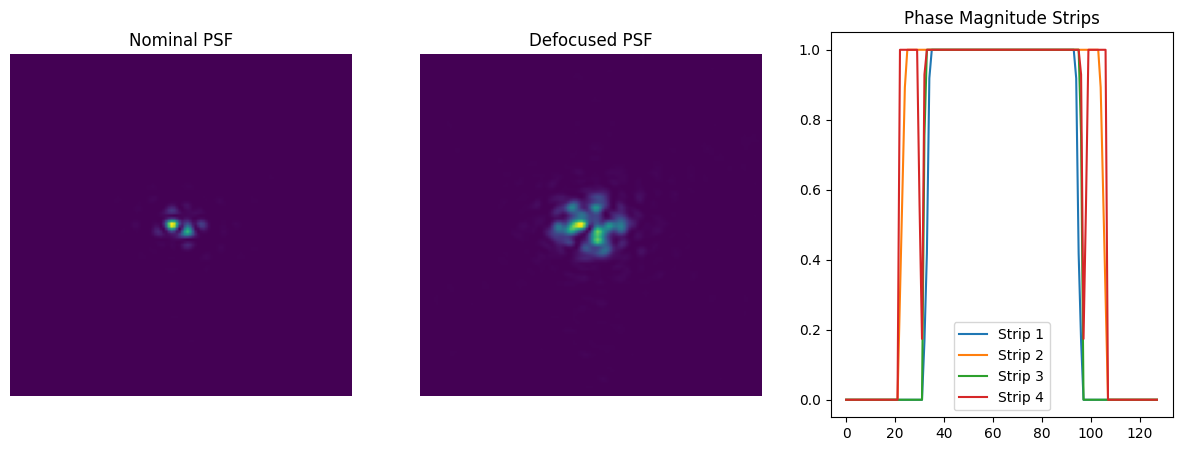

{'primary_1_piston': 2.348243236541748,
 'primary_2_piston': 1.986203670501709,
 'primary_3_piston': 10.286273956298828}

In [41]:
predict_ptt_from_arrays(model, config, psf_nominal = img_nominal, psf_defocus= img_defocused, device="cpu")